# Lab 4: Comprehensive Security Assessment

## Objectives
- Integrate multiple testing frameworks
- Build automated assessment pipeline
- Generate security reports
- Provide remediation recommendations

## Install Required Packages

This lab requires `adversarial-robustness-toolbox` and `textattack`:

In [12]:
# Install required packages if not already installed
try:
    import art
    print("✓ ART already installed")
except ImportError:
    print("Installing adversarial-robustness-toolbox...")
    !pip install -q adversarial-robustness-toolbox==1.17.0
    print("✓ ART installed")

try:
    import textattack
    print("✓ TextAttack already installed")
except ImportError:
    print("Installing textattack...")
    !pip install -q textattack==0.3.10
    print("✓ TextAttack installed")

✓ ART already installed
✓ TextAttack already installed


## Setup and Imports

In [13]:
import torch
import numpy as np
import pandas as pd
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
from textattack.attack_recipes import TextFoolerJin2019
from textattack.models.wrappers import HuggingFaceModelWrapper
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import json

# Detect device (supports CUDA, Apple Silicon MPS, and CPU)
if torch.cuda.is_available():
    device = 'cuda'
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
print(f'Device: {device}')

Device: mps


## Part 1: Security Assessment Framework

In [14]:
class ComprehensiveSecurityAssessment:
    def __init__(self, model, test_data, test_labels):
        self.model = model
        self.test_data = test_data
        self.test_labels = test_labels
        self.results = {}
        self.timestamp = datetime.now()
    
    def run_adversarial_tests(self, classifier):
        """Run adversarial robustness tests"""
        attacks = {
            'FGSM': FastGradientMethod(classifier, eps=0.3),
            'PGD': ProjectedGradientDescent(classifier, eps=0.3, max_iter=40)
        }
        
        results = {}
        for name, attack in attacks.items():
            x_adv = attack.generate(x=self.test_data)
            predictions = classifier.predict(x_adv)
            accuracy = np.mean(np.argmax(predictions, axis=1) == self.test_labels)
            results[name] = accuracy
        
        return results
    
    def calculate_metrics(self, attack_results, baseline_acc):
        """Calculate security metrics"""
        metrics = {
            'baseline_accuracy': baseline_acc,
            'avg_robustness': np.mean(list(attack_results.values())),
            'worst_case': np.min(list(attack_results.values())),
            'robustness_score': (np.mean(list(attack_results.values())) / baseline_acc) * 100
        }
        return metrics
    
    def generate_recommendations(self, metrics):
        """Generate security recommendations"""
        recommendations = []
        
        if metrics['robustness_score'] < 50:
            recommendations.append('CRITICAL: Implement adversarial training immediately')
            recommendations.append('Add input preprocessing defenses')
            recommendations.append('Consider ensemble methods')
        elif metrics['robustness_score'] < 70:
            recommendations.append('WARNING: Moderate vulnerability detected')
            recommendations.append('Implement input validation')
            recommendations.append('Add detection mechanisms')
        else:
            recommendations.append('Model shows good robustness')
            recommendations.append('Continue monitoring')
        
        return recommendations
    
    def generate_report(self):
        """Generate comprehensive report"""
        report = {
            'timestamp': self.timestamp.isoformat(),
            'summary': self.results.get('metrics', {}),
            'attack_results': self.results.get('attacks', {}),
            'recommendations': self.results.get('recommendations', [])
        }
        return report

print('✓ Assessment framework initialized')

✓ Assessment framework initialized


## Part 2: Run Comprehensive Assessment

In [15]:
# Load sample model and data
from torchvision import datasets, transforms
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 128)  # 28->26->13->11->5, so 64*5*5=1600
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 5 * 5)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleCNN().to(device)

# Load MNIST test data
transform = transforms.ToTensor()
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

x_test, y_test = next(iter(test_loader))
x_test = x_test.numpy()
y_test = y_test.numpy()

print(f'Test data: {x_test.shape}')

Test data: (100, 1, 28, 28)


In [16]:
# Wrap model with ART
classifier = PyTorchClassifier(
    model=model,
    loss=nn.CrossEntropyLoss(),
    input_shape=(1, 28, 28),
    nb_classes=10,
    clip_values=(0, 1)
)

# Get baseline accuracy
predictions = classifier.predict(x_test)
baseline_acc = np.mean(np.argmax(predictions, axis=1) == y_test)

print(f'Baseline accuracy: {baseline_acc:.2%}')

Baseline accuracy: 13.00%


In [17]:
# Run comprehensive assessment
assessment = ComprehensiveSecurityAssessment(model, x_test, y_test)

print('Running adversarial tests...')
attack_results = assessment.run_adversarial_tests(classifier)

print('\nAttack Results:')
for name, acc in attack_results.items():
    print(f'  {name}: {acc:.2%}')

assessment.results['attacks'] = attack_results

Running adversarial tests...


PGD - Batches:   0%|          | 0/4 [00:00<?, ?it/s]


Attack Results:
  FGSM: 11.00%
  PGD: 10.00%


## Part 3: Calculate Metrics and Generate Report

In [18]:
# Calculate metrics
metrics = assessment.calculate_metrics(attack_results, baseline_acc)
assessment.results['metrics'] = metrics

print('\nSecurity Metrics:')
print('='*50)
for key, value in metrics.items():
    if isinstance(value, float):
        print(f'{key}: {value:.2%}' if value <= 1 else f'{key}: {value:.1f}')
    else:
        print(f'{key}: {value}')


Security Metrics:
baseline_accuracy: 13.00%
avg_robustness: 10.50%
worst_case: 10.00%
robustness_score: 80.8


In [19]:
# Generate recommendations
recommendations = assessment.generate_recommendations(metrics)
assessment.results['recommendations'] = recommendations

print('\nRecommendations:')
for i, rec in enumerate(recommendations, 1):
    print(f'{i}. {rec}')


Recommendations:
1. Model shows good robustness
2. Continue monitoring


In [20]:
# Generate full report
report = assessment.generate_report()

# Save to JSON
with open('security_assessment_report.json', 'w') as f:
    json.dump(report, f, indent=2)

print('\n✓ Report saved to security_assessment_report.json')


✓ Report saved to security_assessment_report.json


## Part 4: Visualize Results

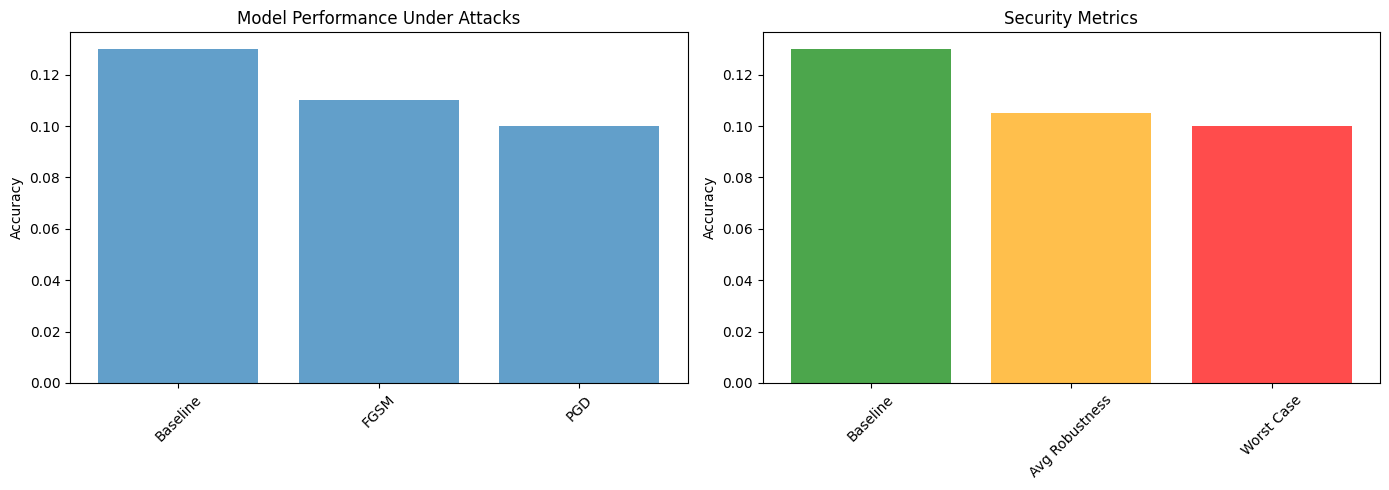

✓ Visualization saved


In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Attack results
attack_names = list(attack_results.keys())
accuracies = list(attack_results.values())

axes[0].bar(['Baseline'] + attack_names, [baseline_acc] + accuracies, alpha=0.7)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Performance Under Attacks')
axes[0].tick_params(axis='x', rotation=45)

# Metrics radar
categories = ['Baseline', 'Avg Robustness', 'Worst Case']
values = [metrics['baseline_accuracy'], metrics['avg_robustness'], metrics['worst_case']]

axes[1].bar(categories, values, alpha=0.7, color=['green', 'orange', 'red'])
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Security Metrics')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('security_assessment.png', dpi=300)
plt.show()

print('✓ Visualization saved')

## Part 5: CI/CD Integration Example

In [22]:
def security_test_for_ci(model, test_data, test_labels, threshold=0.6):
    """Security test for CI/CD pipeline"""
    classifier = PyTorchClassifier(
        model=model,
        loss=nn.CrossEntropyLoss(),
        input_shape=(1, 28, 28),
        nb_classes=10
    )
    
    # Run quick test
    attack = FastGradientMethod(classifier, eps=0.3)
    x_adv = attack.generate(x=test_data)
    predictions = classifier.predict(x_adv)
    accuracy = np.mean(np.argmax(predictions, axis=1) == test_labels)
    
    # Check threshold
    passed = accuracy >= threshold
    
    return {
        'passed': passed,
        'accuracy': accuracy,
        'threshold': threshold,
        'message': f'Security test {'PASSED' if passed else 'FAILED'}: {accuracy:.2%} vs {threshold:.2%}'
    }

# Test
result = security_test_for_ci(model, x_test, y_test, threshold=0.5)
print(result['message'])

if not result['passed']:
    print('⚠️  Model failed security threshold!')

Security test FAILED: 10.00% vs 50.00%
⚠️  Model failed security threshold!


## Exercise

Extend the assessment framework to include:
1. Privacy tests (membership inference)
2. Fairness evaluation
3. Multiple defense strategies
4. Automated remediation suggestions